<a href="https://colab.research.google.com/github/Areeff10/customer_support_agent/blob/main/Customer_support_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import os
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from IPython.display import display , Image

In [163]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

In [164]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

In [165]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [166]:
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash",convert_system_message_to_human=True, api_key=GOOGLE_API_KEY,temperature = 0.1)

In [167]:
llm = ChatGroq(api_key = GROQ_API_KEY, model = "llama-3.3-70b-versatile",temperature = 0.1)

In [168]:
def categorize(state: State) -> State:
  "Technical, Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query": state["query"]}).content
  return {"category": category}

In [169]:
def analyze_sentiment(state: State) -> State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query"
      "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  return {"sentiment": sentiment}

In [170]:
def handle_billing(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

In [171]:
def handle_general(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

In [172]:
def escalate(state: State):
    state["response"] = "This query has been escalated to a human agent due to its negative sentiment."
    return state

In [173]:
def handle_technical(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

In [174]:
def route_query(state: State)->State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

In [175]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,{
        "handle_technical" : "handle_technical",
        "handle_billing" :  "handle_billing",
        "handle_general" : "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app  = workflow.compile()

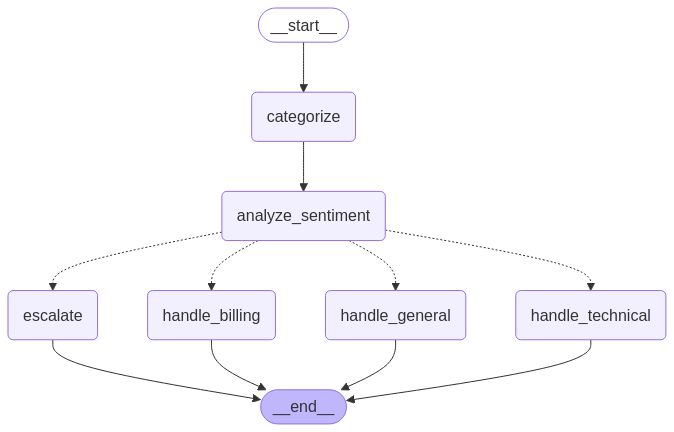

In [176]:
display(Image(app.get_graph().draw_mermaid_png()))

In [181]:
def run_customer_support(query: str):
  results = app.invoke({"query": query})
  return {
      "category":results['category'],
      "sentiment":results['sentiment'],
      "response": results['response']
  }

### Testing 1

In [182]:
query = "My internet connection is gone it's not working, Can you help me?"
result = run_customer_support(query)
print("----------------------------------------------------------------------------------------------------------------------------")
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


----------------------------------------------------------------------------------------------------------------------------
Query: My internet connection is gone it's not working, Can you help me?
Category: The customer query can be categorized as: Technical.

The query is related to a technical issue with the customer's internet connection, which is not working. This requires assistance from a technical support team to troubleshoot and resolve the issue.
Sentiment: Neutral. 

The customer is stating a problem with their internet connection, but they are not expressing any emotion such as frustration or anger, and are instead asking for help in a polite manner.
Response: I'm so sorry to hear that your internet connection is not working. I'd be happy to help you troubleshoot the issue. Can you please try a few things to help me narrow down the problem?

1. **Restart your router**: Sometimes, a simple reboot can resolve the issue. Try unplugging the power cord from your router, waiting 

### Testing 2

In [180]:
query = "where can i find my receipt"
result = run_customer_support(query)
print("----------------------------------------------------------------------------------------------------------------------------")
print(f"Query: {query}")
print(f"Category: {result['category']}\n")
print(f"Sentiment: {result['sentiment']}\n")
print(f"Response: {result['response']}\n")
print("\n")

----------------------------------------------------------------------------------------------------------------------------
Query: where can i find my receipt
Category: The customer query "where can I find my receipt" can be categorized as: Billing.

Sentiment: Neutral. The customer is simply asking for information about their receipt, without expressing any emotion or sentiment, either positive or negative.

Response: I'd be happy to help you locate your receipt. There are a few possible places you can check, depending on how you made your purchase. Here are some suggestions:

1. **Email**: If you made an online purchase, check your email inbox for a confirmation email that may include your receipt.
2. **Order history**: If you have an account with the retailer, log in and check your order history. Your receipt may be available to view or print from there.
3. **Store location**: If you made a purchase in-store, you can try contacting the store directly and asking if they have a copy 